## Library Import

In [12]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

## Load CSV Data

In [13]:
aisle = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
train = pd.read_csv('order_train.csv')

## Analyse in Spark

In [14]:
#Spark Initiation
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("InstacartData") \
        .getOrCreate()

## Loading Pandas df into Spark DF

In [15]:
df_aisle = spark.createDataFrame(aisle)
df_departments = spark.createDataFrame(departments)
df_products = spark.createDataFrame(products)
df_orders = spark.createDataFrame(orders)
df_train = spark.createDataFrame(train)

In [16]:
%matplotlib inline

In [17]:
df_train.printSchema()

root
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- add_to_cart_order: long (nullable = true)
 |-- reordered: long (nullable = true)



######   Q1.)  What hour of day do people usually order from Instacart?

In [18]:
#Method:
#SELECT order_hour_of_day, count(order_id)
#FROM orders
#GROUP BY order_hour_of_day
#ORDER BY order_hour_of_day

In [19]:
hours = df_orders.groupBy(df_orders.order_hour_of_day) \
        .count() \
        .sort(df_orders.order_hour_of_day) \
        .toPandas()

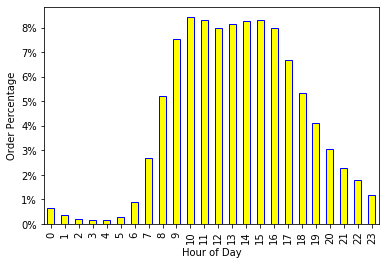

In [20]:
hour_sum = hours['count'].sum()
hours['count'] /= hour_sum
hour_plot = hours['count'].plot(kind='bar', color = 'yellow', edgecolor = 'blue')
hour_plot.set_ylabel("Order Percentage")
hour_plot.set_xlabel("Hour of Day")
hour_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'
                                                  .format(y)))

###### Q2.) What day of week do people usually order from Instacart?

In [21]:
#Method:
#SELECT order_dow, count(order_id)
#FROM orders
#GROUP BY order_dow
#ORDER BY order_dow

In [22]:
day_week = df_orders.groupBy(df_orders.order_dow) \
           .count() \
           .sort(df_orders.order_dow) \
           .toPandas()

In [23]:
def week(nday):
    return{
        0:'sat',
        1:'sun',
        2:'mon',
        3:'tue',
        4:'wed',
        5:'thu',
        6:'fri',
    }.get(nday, 'nan')

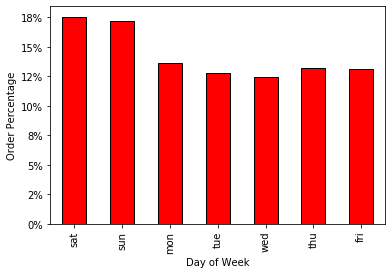

In [24]:
day_sum = day_week['count'].sum()
day_week['count'] /= day_sum
day_plot = day_week['count'].plot(kind='bar', color = 'red', edgecolor = 'black')
day_plot.set_ylabel("Order Percentage")
day_plot.set_xlabel("Day of Week")
day_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
day_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: week(x)))

###### Q3.) How often do users order again?

In [25]:
#Method:
#SELECT days_since_prior_order, count(order_id)
#FROM orders
#GROUP BY days_since_prior_order
#ORDER BY days_since_prior_order

In [26]:
reorder = df_orders.groupBy(df_orders.days_since_prior_order) \
          .count() \
          .sort(df_orders.days_since_prior_order) \
          .toPandas()

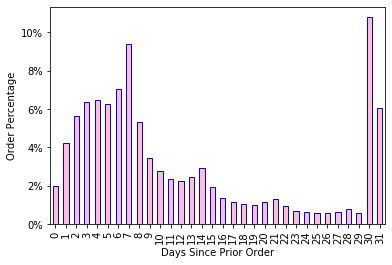

In [27]:
reorder_sum = reorder['count'].sum()
reorder['count'] /= reorder_sum
reorder_plot = reorder['count'].plot(kind='bar', color='pink', edgecolor='blue')
reorder_plot.set_ylabel("Order Percentage")
reorder_plot.set_xlabel("Days Since Prior Order")
reorder_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

###### Q4.) How many times do users order?

In [28]:
#SELECT user_id, max(order_number)

In [29]:
orders_count = df_orders.groupBy(df_orders.user_id) \
               .agg({"order_number":"max"}) \
               .withColumnRenamed('max(order_number)','total_orders') \
               .selectExpr('10 * FLOOR(total_orders/10.0)', 'user_id') \
               .toDF('total_orders_cat', 'user_id') \
               .groupBy('total_orders_cat') \
               .count() \
               .sort('total_orders_cat')\
               .toPandas()

In [30]:
def formatTotalOrders(x):
    real_x = x * 10
    return {
        0: '(0,10)',
        100: '[100,inf)',
    }.get(real_x, '[%d,%d)' % (real_x, real_x+10))

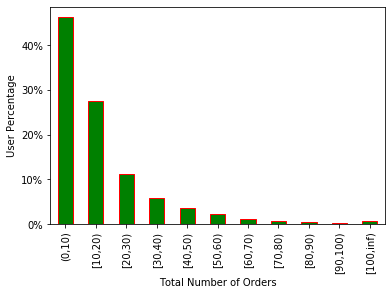

In [31]:
times_sum = orders_count['count'].sum()
orders_count['count'] /= times_sum
times_plot = orders_count.plot(kind='bar', x='total_orders_cat', y ='count', 
                               color ='Green', edgecolor='red' ,legend=False)
times_plot.set_ylabel("User Percentage")
times_plot.set_xlabel("Total Number of Orders")
times_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
times_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: formatTotalOrders(x)))

###### Q5.) What are the most popular groceries?

In [32]:
#SELECT TOP (15) * FROM
#SELECT product_name, COUNT(order_id) as count FROM order_products
#JOIN products ON order_products.product_id = products.product_id
#GROUPBY products.product_id
#ORDER BY count

In [33]:
# Find Product IDs of Top 15 BestSelling Products
top15 = df_train.groupBy(df_train.product_id) \
    .count() \
    .sort('count', ascending=False) \
    .limit(15)
# Find Product Names    
top15 = top15.join(df_products, df_products.product_id == top15.product_id) \
    .select('product_name', 'count') \
    .sort('count', ascending=False) \
    .toPandas()

In [34]:
total_orders = df_train.select('order_id').distinct().count()

In [35]:
def fpn(i):
    return top15.product_name[i]

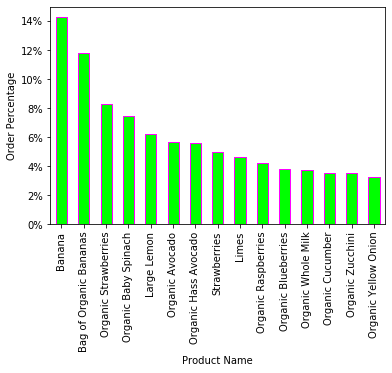

In [36]:
top15['count'] /= total_orders
top15_plot = top15.plot(kind='bar', color = 'lime',edgecolor='fuchsia', legend=False)
top15_plot.set_ylabel("Order Percentage")
top15_plot.set_xlabel("Product Name")
top15_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
top15_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: fpn(x)))

###### Q6.) What aisles are reordered most often?

In [37]:
#SELECT TOP (15) * FROM
#SELECT aisle, mean(reordered) as reorder_ratio
#FROM order_products
#JOIN products ON order_products.product_id = products.product_id
#JOIN aisles ON products.aisle_id = aisles.aisle_id
#GROUPBY aisle
#ORDER BY reorder_ratio

In [38]:
df_products.printSchema()

root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: long (nullable = true)
 |-- department_id: long (nullable = true)



In [41]:
reorder_rate = df_train.join(df_products, df_products.product_id == df_train.product_id) \
            .groupBy('aisle_id') \
            .agg({"reordered":"mean"}) \
            .withColumnRenamed('avg(reordered)', 'reorder_rate') \
            .sort('reorder_rate', ascending=False) \
            .limit(15)
reorder_result=reorder_rate.join(df_aisle, df_aisle.aisle_id == reorder_rate.aisle_id) \
    .select('aisle', 'reorder_rate') \
    .sort('reorder_rate', ascending=False) \
    .toPandas()

In [42]:
def fan(i):
    return reorder_result.aisle[i]

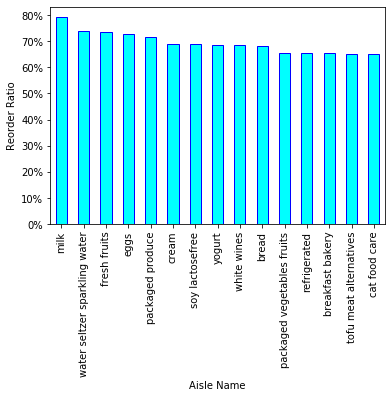

In [45]:
rrp = reorder_result.plot(kind = 'bar', color = 'cyan', edgecolor = 'b',legend= False)
rrp.set_ylabel("Reorder Ratio")
rrp.set_xlabel("Aisle Name")
rrp.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
rrp.xaxis.set_major_formatter(FuncFormatter(lambda x, _: fan(x)))